## Optimization Dynamics: an Interactive Tool

This notebook concentrates on improving your intuitive understanding of the methods employed by
[Cooper](https://github.com/cooper-org/cooper) for solving constrained optimization problems.

To achieve so, we consider a [toy constrained optimization problem](#cmp) in 2D.
We provide an interactive widget which shows the optimization path realized when solving the problem using [Cooper](https://github.com/cooper-org/cooper), for a variety of hyper-parameter settings.
We will guide you through specific settings which highlight some interesting properties of gradient descent-ascent schemes for solving min-max Lagrangian based problems.
You can also play with the widget to explore the behavior of optimization on your own.

If you are interested in a tutorial on how to use [Cooper](https://github.com/cooper-org/cooper),
visit [this tutorial](https://github.com/cooper-org/cooper/tree/master/tutorials/logistic_regression.ipynb).
For a fully realized application in the context of deep learning, visit
[this repository](https://github.com/gallego-posada/constrained_l0).

> **Acknowledgement**
> The presented visualizations and optimization problems follow
> closely the blogposts by [Degrave and Korshunova (2021a, 2021b)](#blog1)


TODO: update TOC
## Table of Contents:
* [Setup](#setup)
* [Constrained Minimization Problem](#cmp)
* [Widget](#widget)
* [References](#references)

### Setup <a class="anchor" id="setup"></a>
Install Cooper, with the requirements for running `examples`.

!pip install -e git+https://github.com/cooper-org/cooper#egg=.[examples]

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

import cooper

from cooper import CMPState, ConstraintGroup, ConstraintState

from widget import Toy2DWidget

%matplotlib inline

torch.manual_seed(0)
np.random.seed(0)

## Constrained Minimization Problem <a class="anchor" id="cmp"></a>

Consider the following constrained optimization problem on
 the 2D domain $(x, y) \in [0,\pi/2] \times [0,\infty]$

$$\begin{align*}
\underset{x, y}{\text{min}}\quad f(x,y) &:= \left(1 - \text{sin}(x) \right) \ \big(1+(y - 1)^2\big) & \tag{1} \\
s.t. \quad  g(x,y) &:= \left(1 - \text{cos}(x) \right)\ \big(1+(y-1)^2\big) - \epsilon \leq 0 & \\
\end{align*}$$

given some $\epsilon \geq 0 $.
Note how both $f$ and $g$ are convex functions in the specified domain.
As such, this constrained minimization problem is a convex problem.

The following class implements this CMP:

In [2]:
class Toy2DCMP(cooper.ConstrainedMinimizationProblem):
    def __init__(
        self,
        ineq_group: ConstraintGroup,
        epsilon: float = 1.0,
        problem_type: str = "Convex",
    ) -> None:
        self.ineq_group = ineq_group
        self.problem_type = problem_type
        self.epsilon = epsilon
        super().__init__()

    def compute_cmp_state(self, params):
        """This function evaluates the objective function and constraint
        defect. It updates the attributes of this CMP based on the results."""

        x, y = params[:, 0], params[:, 1]

        if self.problem_type == "Convex":
            f = (1 - torch.sin(x)) * (1 + (y - 1.0) ** 2)
            # In standard form (defect <= 0)
            g = (1 - torch.cos(x)) * (1 + (y - 1.0) ** 2) - self.epsilon
        elif self.problem_type == "Concave":
            f = torch.sin(x) * (1 + (y - 1.0) ** 2)
            # in standard form (defect <= 0)
            g = torch.cos(x) * (1 + (y - 1.0) ** 2) - self.epsilon
        else:
            raise ValueError("Unknown problem type.")

        self.ineq_group.state = ConstraintState(violation=g)

        # Store the values in a CMPState as attributes
        state = cooper.CMPState(loss=f, observed_constraints=[self.ineq_group])

        return state

Recall that [Cooper](https://github.com/cooper-org/cooper) employs a flexible approach to solving problems like Eq. (1). First, it formulates the Lagrangian associated with the optimization problem. Then, it employs saddle-point optimizing techniques on the Lagrangian's min-max game. The Lagrangian and its respective game are as follows:

$$ \begin{align*}
& \underset{x, y}{\text{min}}\ \underset{\lambda \geq 0}{\text{max}}\ f(x,y) +
\lambda \, g(x,y) \tag{2} \\
& \underset{x, y}{\text{min}}\ \underset{\lambda \geq 0}{\text{max}}\,
\big(1 - \text{sin}(x) \big) \ \big(1+(y-1)^2\big) +
\lambda \big(1 - \text{cos}(x) \big)\ \big(1+(y-1)^2\big)  \\
\end{align*} $$

### Bonus: non-convex $f(x, y)$ and $g(x, y)$.

Associated with `Toy2DCMP(problem_type="Concave")`

Consider a similar optimization problem to Eq. (1), also on $[0,\pi/2] \times [0,\infty]$:

$$\begin{align*}
\underset{x, y}{\text{min}}\quad f(x,y) &:= \text{sin}(x) \ \big(1+(y - 1)^2\big) & \tag{3} \\
s.t. \quad  g(x,y) &:= \text{cos}(x)\ \big(1+(y-1)^2\big) - \epsilon \leq 0 & \\
\end{align*}$$

given some $\epsilon \geq 0 $.
$f$ and $g$ are concave functions with respect to $x$ in this case.

## Widget <a class="anchor" id="widget"></a>

The `Toy2DWidget` class implements a widget which shows the optimization dynamics of [Cooper](https://github.com/cooper-org/cooper) when solving the problems in Eq. (1) and Bonus: Eq. (3). The widget keeps track of various metrics throughout the optimization of Eq. (2) via simultaneous gradient descent on the parameters $(x,y)$ and gradient ascent on the dual variable $\lambda$.

You can play by adjusting different hyper-parameters (optimizer type, learning rate) of the widget to see how they affect the optimization path.

This first widget is flexible as it allows you to tune all of the main components required for doing optimization with [Cooper](https://github.com/cooper-org/cooper).
In the following sections of this notebook, we will guide your exploration to help develop some intuitions with respect to the optimization methods behind [Cooper](https://github.com/cooper-org/cooper). Feel free to come back here at any moment to try out interesting dynamics!

Run the widget to get a sample trajectory.

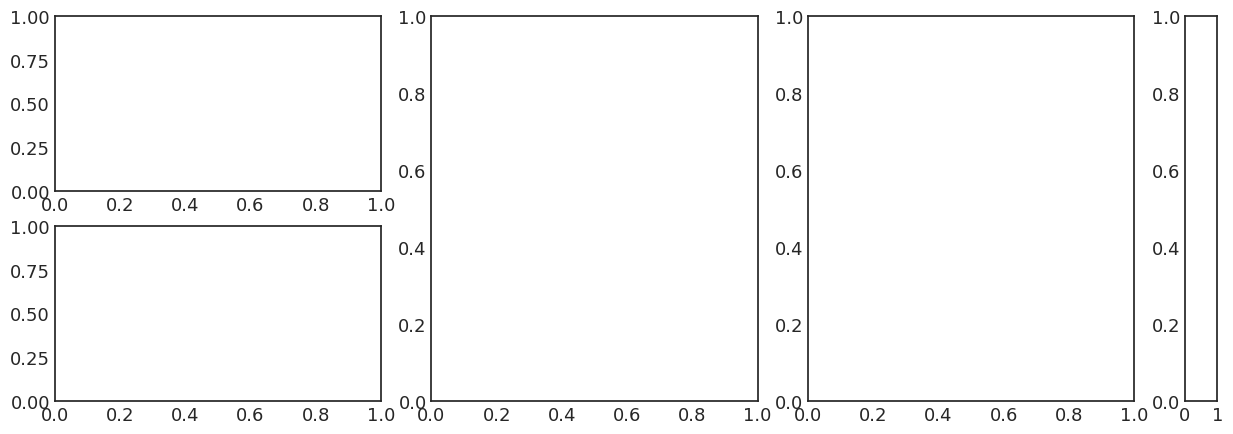

In [18]:
widget = Toy2DWidget(Toy2DCMP)

### Reading the plots

Run the next cell. This widget has some hyper-parameters fixed, but you can still tune the constraint level $\epsilon$ and the initialization.



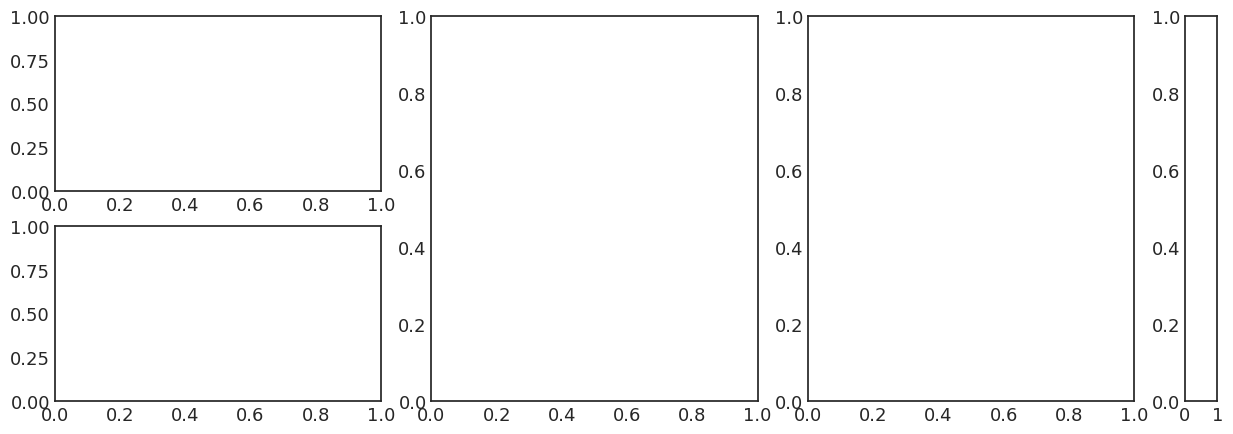

In [19]:
widget = Toy2DWidget(
    Toy2DCMP,
    num_iters=300,
    problem_type="Convex",
    primal_optim="Adam",
    primal_lr=0.02,
    dual_optim="SGD",
    dual_lr=0.05,
    x=0.7,
    y=2.0,
    extrapolation=False,
    dual_restarts=False,
)

**First column**\
On the top left, the objective $f$ is displayed. In this example, it decreases along training, but not on a monotonic fashion.
The value of the constraint $g$ and the Lagrange multiplier $\lambda$ are presented on the bottom left panel. The constraint is asymptotically satisfied for $\epsilon = 0.7$.

**Middle column**\
The middle plot shows the optimization path followed in $(x, y)$ space. The feasible set is highlighted on blue. Level curves for the loss are presented in gray. For this specific run, parameters constantly come in and out of the feasible region, whilst consistently moving towards the optimum.

**Last column**\
The panel on the right shows the optimization path followed in $(f, g)$ space. As such, points to the left of the plot correspond to solutions with low objective values and points towards the bottom correspond to solutions with lower constraint values. The black curve represents the Pareto front of non-dominated solutions on the joint optimization of $(f,g)$. Depending on the constraint level set, the optimal solution of the constrained optimization problem falls in different points of the Pareto front. Finally, the highlighted blue region shows the feasible region of the considered problem.

> **Exercise**
> * Set $\epsilon > 1$. What do you observe? Is the multiplier increasing? At what rate does the value of the multiplier change?
> * Set $\epsilon < 0$. At which iteration is the constraint satisfied?
> * Move $\epsilon$ in $(0, 1)$. What is the resulting objective value when the constraint is tighter? How does the multiplier behave?


### The Lagrangian multipliers

The effective use of [Cooper](https://github.com/cooper-org/cooper) requires an understanding of the behavior of the Lagrangian multipliers $\lambda$ associated with each constraint. Recall from Eq. (2) the problem we are solving:
$$ \begin{align*}
& \underset{x, y}{\text{min}}\ \underset{\lambda \geq 0}{\text{max}}\ f(x,y) +
\lambda \, g(x,y) \\
\end{align*} $$


A large value of $\lambda$ is reflected in a large relative contribution of $g$ towards the update of $(x, y)$. Conversely, when $\lambda = 0$, only gradients of $f$ will be used on a descent step on $(x, y)$.

Additionally, the (gradient ascent) update on the multiplier is:
$$ \begin{align*}
    \lambda_{t+1} = \lambda_t + \eta_{\lambda}  \, g(x_t,y_t) \\
\end{align*} $$
Therefore, changes on the multiplier depend directly on the value of the constraint, as mediated by the learning rate $\eta_{\lambda}$. The value of the learning rate will be reflected in the eagerness to satisfy the constraint. As with other hyper-parameters, choosing its value is an important and complex task.


> **Note**
> The actual update on $\lambda$ differs based on the dual optimizer chosen. Nonetheless, the core intuition between the relationship of the constraint value and the multiplier still holds.

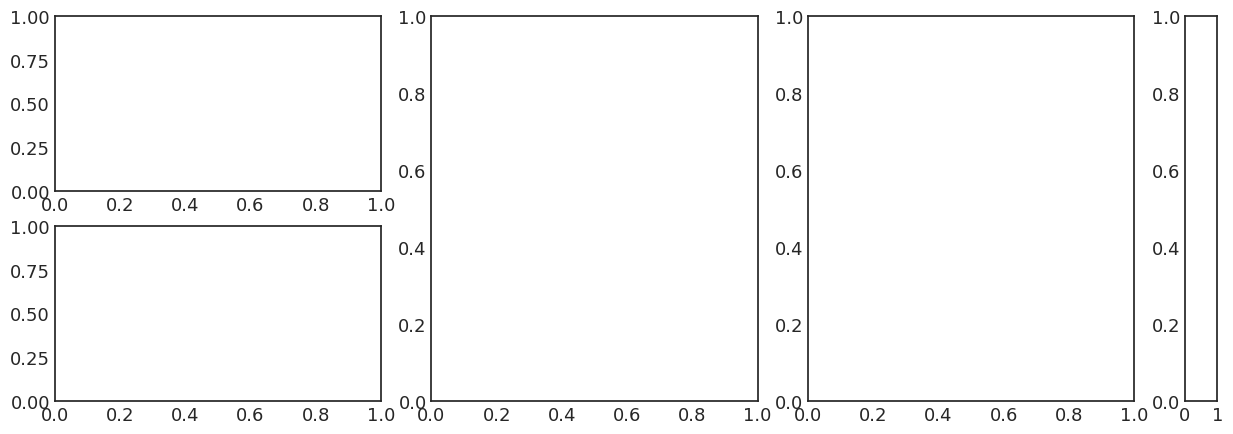

In [20]:
widget = Toy2DWidget(
    Toy2DCMP,
    num_iters=200,
    epsilon=0.7,
    problem_type="Convex",
    primal_optim="SGD",
    primal_lr=0.02,
    dual_optim="SGD",
    x=0.7,
    y=2.0,
    extrapolation=False,
    dual_restarts=False,
)

The multiplier does not increase during the first few iterations as the constraint is initially satisfied. During this period, the optimization focuses on the objective function, resulting in a violation of the constraint. The multiplier then kicks in to balance the importance $f$ and $g$. Thereafter, the constraint presents dampened oscillations around 0.


> **Exercise**
> * Try different values of the dual learning rate. What do you observe? 
> * Are there oscillations in the value of the constraint or multiplier? Does their amplitude or frequency change for different dual learning rates?
> * Is the constraint satisfied by the end of training?

### Dual Restarts

> **TODO**
> Dual restarts seems to be detrimental in this specific problem. Maybe because $f$ and $g$ present a nearly orthogonal trade-off?

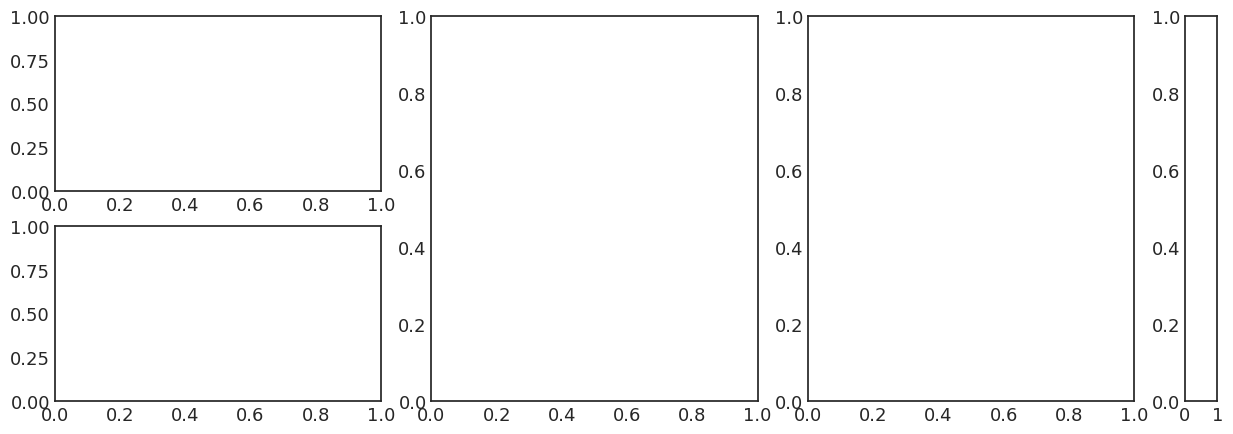

In [21]:
widget = Toy2DWidget(
    Toy2DCMP,
    num_iters=1000,
    epsilon=0.7,
    problem_type="Convex",
    primal_optim="SGD",
    primal_lr=0.02,
    dual_optim="SGD",
    dual_lr=0.5,
    x=0.7,
    y=1.8,
    extrapolation=False,
)

### Extrapolation

The are no convergence guarantees for gradient descent-ascent updates on general min-max games. Korpelevich (1976) and Gidel et. al (2019)

> **TODO**
> Non-convex case often gets stuck at the corners. Otherwise, it oscillates even for Extrapolation!


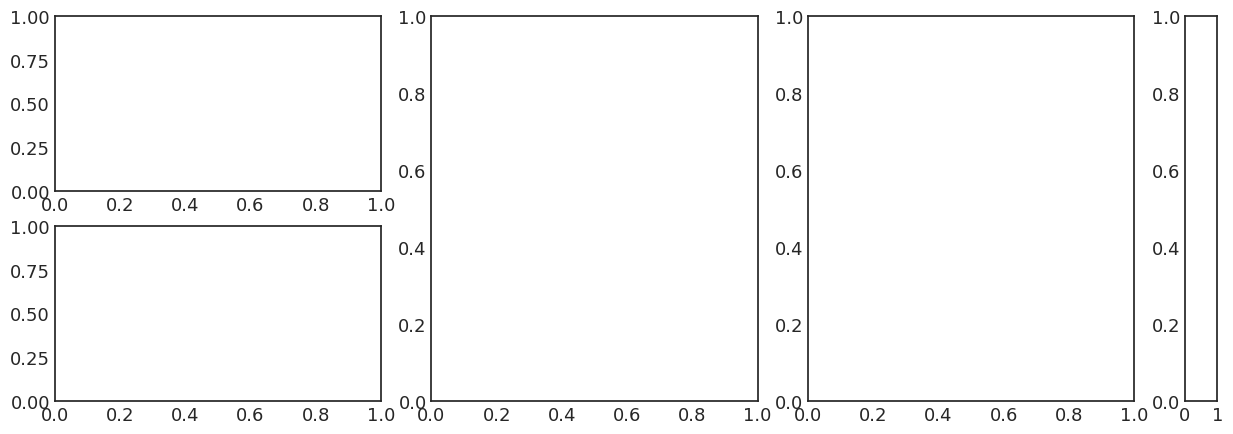

In [22]:
widget = Toy2DWidget(
    Toy2DCMP,
    num_iters=1000,
    epsilon=0.7,
    problem_type="Convex",
    primal_optim="SGD",
    primal_lr=0.02,
    dual_optim="SGD",
    dual_lr=0.5,
    x=0.7,
    y=1.8,
    dual_restarts=False,
)

## References <a class="anchor" id="references"></a>

- J. Degrave and I. Korshunova. Why machine learning algorithms are hard to tune and how to fix it. Engraved,   [blog](www.engraved.blog/why-machine-learning-algorithms-are-hard-to-tune/), 2021. <a class="anchor" id="blog1"></a>
- J. Degrave and I. Korshunova. How we can make machine learning algorithms tunable. Engraved,   [blog](https://www.engraved.blog/how-we-can-make-machine-learning-algorithms-tunable/), 2021. <a class="anchor" id="blog2"></a>
- G. Gidel, H. Berard, G. Vignoud, P. Vincent, and S. Lacoste-Julien. A Variational Inequality
Perspective on Generative Adversarial Networks. In ICLR, 2019.
- G. M. Korpelevich. The extragradient method for finding saddle points and other problems. Matecon, 1976.